In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.examples.tutorials.mnist import input_data

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1. Convolution Neural Network
<br />
## - Network Architecture
###  : Input - Conv - ReLU -Pooling - Conv - ReLU -Pooling - Softmax

In [2]:
# MNIST 데이터 생성
# ont_hot = True는 Y의 레이블이 1이라면 [0,1,0,0,0,0,0,0,0,0] 처럼 0또는 1로 코딩해주는것
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# placeholder로 x, y값을 저장할 공간 할당
# [None, 784]의 의미는 행의 수는 무한대로 받을 수 있다는 뜻 
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])

x_image = tf.reshape(x, [-1,28, 28, 1])
print ("x_image=",x_image)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
x_image= Tensor("Reshape:0", shape=(?, 28, 28, 1), dtype=float32)


In [3]:
print("train_label_shape : ",mnist.train.labels.shape)
print("train_image_shape : ",mnist.train.images.shape)
print("test_label_shape : ",mnist.test.labels.shape)
print("test_image_shape : ",mnist.test.images.shape)

train_label_shape :  (55000, 10)
train_image_shape :  (55000, 784)
test_label_shape :  (10000, 10)
test_image_shape :  (10000, 784)


### 함수 정의

In [4]:
def weight_variable(shape):
    initial = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

- 표준편차를 0.1로 가지는 가중치 함수 정의
- 편의가 0.1인 편의 함수 정의

In [5]:
def con2d(x, w, b):
    layer = tf.nn.relu(tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='SAME')+b)
    return layer

def max_pool(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

- Stride가 1이고, Padding은 0인 convolution 함수 정의
- Stride가 2이고 filter 사이즈가 2*2인 MaxPooling 함수 정의

### CNN Graph 정의

In [6]:
##############################################################################
#Input - Conv1 - ReLU - MaxPooling - Conv2 - ReLU - MaxPooling - FC - SoftMax
##############################################################################

##########################################################
#첫번째 Layer
##########################################################
# 첫번째 Layer의 Convolution Filter 설정
# 5x5크기의 32개의 Filter 생성
W_conv1 = weight_variable([5, 5, 1, 32])
# 32개의 bias 생성
b_conv1 = bias_variable([32])

# 첫번째 Convolution Layer 생성
h_conv1 = con2d(x_image, W_conv1, b_conv1)
# Convolution Output에 대한 2x2 maxpolling
h_pool1 = max_pool(h_conv1)
# Input         -> 28*28
# After Conv    -> 28*28 (5*5 필터, padding=SAME)
# After pooling -> 14*14



##########################################################
#두번째 Layer
##########################################################
# 두번째 Layer의 Filter 설정, 첫번째 Layer의 Filter의 갯수를 32개로 설정하였기 때문에
# depth는 32로 설정
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

# 두번째 Convolution Layer 생성
# 첫번째 Layer의 최종 output인 hpoo1을 입력으로 받음
h_conv2 = con2d(h_pool1, W_conv2, b_conv2)
#Convolution Output에 대한 2X2 Maxpooling
h_pool2 = max_pool(h_conv2)
# Input         -> 14*14
# After Conv    -> 14*14 (5*5 필터, padding=SAME)
# After pooling -> 7*7



##########################################################
#Fully Connected Layer
# : Classification을 위해 3차원 데이터를 
#   1차원 tensor로 변환 후 Drop Out
##########################################################
# 7x7에 해당하는 Fully Connected Filter 설정
# 출력은 1024
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

# 두번째 Layer의 Output size를 통해 Flatten 작업 수행
# Tensor to Vector
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# 드롭아웃되지 않을 확률 값을 저장할 플레이스홀더를 생성 및 Dropout Layer 추가
# drop out : unbalanced weight node들을 삭제 -> 과적합 문제 해결방안임
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# SoftMax 계층 전에 입힐 Filter 설정
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

# 1차 Fully Connectered Layer의 결과를 통해 softmax
y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2) #hypothesis

- (Conv > ReLU > Max Pooling) > (Conv > ReLU > MaxPooling) > (Fully Connect>Drop out > SoftMax) layer 구성

### Training

In [7]:
#초기 설정
learning_rate = 1e-4
batch_size = 100

# model 훈련 및 평가
# cost_fn
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)


#accuracy op 생성
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# 모든 변수 초기화
sess = tf.Session()
sess.run(tf.global_variables_initializer())


# 1스텝 당 100개씩 2천번 학습
for i in range(2000):
    batch = mnist.train.next_batch(batch_size)
    if i%10 == 0:
        result = sess.run(accuracy, feed_dict={ x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, Training Acc %g"%(i, result))
        sess.run(optimizer,feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("Test Acc %g"% sess.run(accuracy, feed_dict={
       x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, Training Acc 0.1
step 10, Training Acc 0.09
step 20, Training Acc 0.11
step 30, Training Acc 0.12
step 40, Training Acc 0.1
step 50, Training Acc 0.11
step 60, Training Acc 0.13
step 70, Training Acc 0.17
step 80, Training Acc 0.15
step 90, Training Acc 0.19
step 100, Training Acc 0.22
step 110, Training Acc 0.18
step 120, Training Acc 0.18
step 130, Training Acc 0.31
step 140, Training Acc 0.27
step 150, Training Acc 0.29
step 160, Training Acc 0.34
step 170, Training Acc 0.42
step 180, Training Acc 0.43
step 190, Training Acc 0.4
step 200, Training Acc 0.43
step 210, Training Acc 0.46
step 220, Training Acc 0.47
step 230, Training Acc 0.47
step 240, Training Acc 0.61
step 250, Training Acc 0.56
step 260, Training Acc 0.57
step 270, Training Acc 0.6
step 280, Training Acc 0.58
step 290, Training Acc 0.51
step 300, Training Acc 0.51
step 310, Training Acc 0.58
step 320, Training Acc 0.62
step 330, Training Acc 0.63
step 340, Training Acc 0.57
step 350, Training Acc 0.65
step 36

In [8]:
# Testset accuracy 계산
print('Accuracy:', sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob:1.0}))

Accuracy: 0.9138


### Test

예측값:  [3]


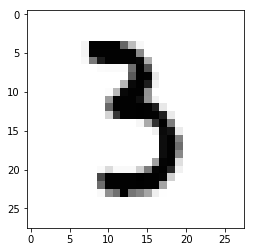

In [9]:
# 랜덤하게 이미지를 뽑아서 이미지 인식 테스트 수행
r = random.randint(0, mnist.test.num_examples - 1)

# 해당 이미지 및 예측값

print("예측값: ", sess.run(tf.argmax(y_conv, 1), feed_dict={x: mnist.test.images[r:r + 1], keep_prob: 1}))

plt.imshow(mnist.test.images[r:r + 1].reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()

In [10]:
# 정답
print("정답: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))

정답:  [3]
